In [6]:
#!pip install pyomo

import numpy as np
import pyomo.environ as pyo
from pathlib import *
from pyomo.opt import SolverFactory
from gurobipy import *

#!pip install pyomo
import os
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import time

from datetime import datetime

In [7]:
param = {
"WLSACCESSID": '31c22531-09db-4b06-8466-f0589ec53ca2',
"WLSSECRET": '1db38aec-7d75-4e91-aadb-aed504137cf7',
"LICENSEID": 943442,
}

gurobi_environment = Env(params=param)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 943442
Academic license 943442 - for non-commercial use only - registered to j.___@student.vu.nl


# TSP MODEL to determine next queue

- Position based, index based TSP, model zhang
- Heuristiek? 
- TSP with time windows literatuur
- LKH3 TSP solver
- solvers voor cumulative vehicle routing

In [21]:
def Compute_TSP_Tour(I_min, tilde_n_min, gurobi_environment, theta_min, arrival_rate_Q, mu):
    
    #print(f"I_min = {I_min}\ntilde_n_min = {tilde_n_min}\ntheta_min = {theta_min}")
    
    model = Model(env = gurobi_environment)
    model.Params.LogToConsole = 0

    # Parameters
    M = 1e3
    B_expected = mu 
    rho_Q = arrival_rate_Q * B_expected

    tilde_m_squared_min = len(I_min)
    queues = range(tilde_m_squared_min)
    queues_excl = range(1,tilde_m_squared_min)
    
    # Model Variables
    tour = model.addMVar((tilde_m_squared_min, tilde_m_squared_min), vtype=GRB.BINARY, name = "tour")
    t = model.addMVar(tilde_m_squared_min, vtype= GRB.CONTINUOUS, lb = 0, ub = GRB.INFINITY, name = "t")
    model.addConstr(t[0] == 0)
    
    #Objective 
    model.setObjective(sum(t[i]*tilde_n_min[i] for i in queues_excl)+ sum(tour[k, l]*theta_min[k][l] for k in queues for l in queues if k != l), GRB.MINIMIZE)    
    #model.setObjective(sum(t[i]*tilde_n_min[i] for i in queues_excl), GRB.MINIMIZE)
    
    # Tour constraints
    model.addConstrs((sum(tour[i, j] for j in queues if i != j) <= 1 for i in queues), name="tour_out")
    #model.addConstrs((sum(tour[i, j] for j in queues if i != j) == 1 for i in queues_excl), name="tour_out")

    model.addConstrs((sum(tour[i, j] for i in queues if i != j) == 1 for j in queues_excl), name="tour_in")
    #model.addConstr((sum(tour[i, 0] for i in queues_excl) == 1), name="return_to_first_queue")
    model.addConstr((sum(tour[i, 0] for i in queues_excl) == 0), name="return_to_first_queue")
        
    # Arrival times constraints
    #model.addConstrs((t[j] >= t[i] + (((tilde_n_min[i]*B_expected)+(t[i]*rho_Q))/(1-rho_Q)) + theta_min[i][j] - (M*(1-tour[i,j]))  for i in queues for j in queues_excl if i != j), name="arrival_times")
    model.addConstrs((t[j] >= t[i] + (tilde_n_min[i]*B_expected)+ theta_min[i][j] - (M*(1-tour[i,j]))  for i in queues for j in queues_excl if i != j), name="arrival_times")
    
    
    model.optimize();
    optimality = model.status

    result = tour.X
    aankomsten = t.X    
    
    """VALIDATION CHECK"""
    if (sum(aankomsten) == 0):
        raise ValueError(f"Error with t_i's in TSP")
    """VALIDATION CHECK"""

            
    return result, aankomsten

# Model

In [22]:
def compute_switch_over(tilde_m, tilde_m_squared):
    global m
    
    coordinates_queue_centers = []
    for i in range(tilde_m):
        for j in range(tilde_m):
            coordinates_queue_centers.append([(1/(2*tilde_m)) + (i/tilde_m), (1/(2*tilde_m)) + (j/tilde_m)])
    #print(coordinates_queue_centers)

    theta = np.zeros([tilde_m_squared+1, tilde_m_squared+1])
    for i in range(tilde_m_squared+1):
        for j in range(tilde_m_squared+1):
            if (i == 0 and j > 0):
                distance = np.sqrt(((m/2) - coordinates_queue_centers[j-1][0])**2 + ((m/2) - coordinates_queue_centers[j-1][1])**2);
                #print(j, (m/2) - coordinates_queue_centers[j-1][0], (m/2) - coordinates_queue_centers[j-1][1])
                theta[i][j] = distance
                theta[j][i] = distance
            elif (i < j):
                distance = np.sqrt((coordinates_queue_centers[i-1][0] - coordinates_queue_centers[j-1][0])**2 + (coordinates_queue_centers[i-1][1] - coordinates_queue_centers[j-1][1])**2);
                theta[i][j] = distance
                theta[j][i] = distance
    
    return theta, coordinates_queue_centers

def prep_TSP(tilde_n_Q, theta, current_queue_index, status_traveler):
    tilde_n_minimal_value = 1
    
    if (status_traveler == 1):
        I_min = [current_queue_index]
        tilde_n_min = [0]
    else:
        I_min = [0]
        tilde_n_min = [0] 
        
    index_counter = 0
    for i in range(len(tilde_n_Q)):
        if (tilde_n_Q[i] >= tilde_n_minimal_value):
            I_min.append(i+1)    
            tilde_n_min.append(tilde_n_Q[i])
            index_counter += 1 
      
    theta_min = []
    for j in I_min:
        theta_min_row=[]
        for k in I_min:
            distance_theta = theta[j][k]
            theta_min_row.append(distance_theta)
        theta_min.append(theta_min_row)

        
    #print(f"I_min = {I_min}\ntilde_n_min = {tilde_n_min}\ntheta_min = {theta_min}")
    return I_min, tilde_n_min, theta_min

def compute_queue_index(x_coordinate, y_coordinate):
    global tilde_m; global m;
    
    for i in range(1,tilde_m+1):
        if (x_coordinate <= i*(m/tilde_m)):
            column_index = i;
            break
    
    for j in range(1,tilde_m+1):
        if (y_coordinate <= j*(m/tilde_m)):
            row_index = j;
            break
            
    queue_index = column_index + ((row_index-1)*tilde_m);
    return queue_index;

class demand_object:
    def __init__(self, index, interarrival_time, x_coordinate, y_coordinate, service_time, earliest_arrival):
        self.index = index
        self.interarrival_time = interarrival_time
        self.x_coordinate = x_coordinate
        self.y_coordinate = y_coordinate
        self.service_time = service_time
        self.earliest_arrival = earliest_arrival
        queue_index = compute_queue_index(x_coordinate,y_coordinate)
        self.queue_index = queue_index
        
class result:
    def __init__(self, index, earliest_arrival, completion_time, waiting_time, system_time):
        self.index = index
        self.earliest_arrival = earliest_arrival
        self.completion_time = completion_time
        self.waiting_time = waiting_time
        self.system_time = system_time

def wait_for_arrival():
    global lam; global mu; global m; global number_nodes_in_system; global lower_earliest; global sigma
    A = np.random.exponential(scale = 1/lam, size=1)[0];
    S = np.random.normal(mu, sigma, size = 1)[0]
    X = np.random.uniform(low=0, high=m, size=1)[0];
    Y = np.random.uniform(low=0, high=m, size=1)[0];
    demand = demand_object(number_nodes_in_system+1, A, X, Y, S, lower_earliest + A);
    return demand;

def add_newly_appeared(available_nodes, maximum_time):
    global number_available_nodes_queue
    global number_nodes_in_system
    global lower_earliest
    global simulation_demands_amount
    
    while (number_nodes_in_system < simulation_demands_amount):
        new_available_node = wait_for_arrival();
        if (new_available_node.earliest_arrival <= maximum_time):
            available_nodes[new_available_node.queue_index-1].append(new_available_node);
            number_available_nodes_queue[new_available_node.queue_index-1] += 1;
            number_nodes_in_system += 1;
            lower_earliest += new_available_node.interarrival_time;
        else:
            break;
            
    return available_nodes;

def determine_Nearest_Neighbor(available_nodes_queue, number_available_nodes, current_node):
    minimum_distance = float('inf');
    for i in range(number_available_nodes):
        temp_distance = np.sqrt((current_node.x_coordinate - available_nodes_queue[i].x_coordinate)**2 + (current_node.y_coordinate - available_nodes_queue[i].y_coordinate)**2);
                
        if (temp_distance < minimum_distance):
            next_node = available_nodes_queue[i];
            minimum_distance = temp_distance;
    
    travel_time = minimum_distance
    return next_node, travel_time;
    
    

def simulate_NN_variations_algorithm():
    global simulation_demands_amount; global m; global tilde_m; global tilde_m_squared;
    global number_available_nodes_queue; global number_nodes_in_system; global lower_earliest;
    global current_queue_index; global lam;
    
    #route = [];
    #route.append(result(0,0,0,0,0));
    
    action_traveler = 0; # 0 = traveling to an available demand; 1 = travel to the depot
    status_traveler = 0; # 0 = at depot waiting; 1 = finished serving at a demand
    number_visited_nodes = 0;
    
    available_nodes = []; # Is now a matrix
    for i in range(tilde_m_squared):
        available_nodes.append([])
        
    current_time = 0.0;
    lower_earliest = 0.0;
    
    result_waiting_times_array = [0]*simulation_demands_amount
    
    arrival_rate_Q = lam/tilde_m_squared
    theta, coordinates_queue_centers = compute_switch_over(tilde_m, tilde_m_squared)
    
    start_time_time = time.time()
    
    while (number_visited_nodes < simulation_demands_amount):
        
        """STATUS PRINTING"""
        if ((time.time()-start_time_time)/60 >= 0.5):
            now = datetime.now()
            now_time = now.strftime("%H:%M:%S")
            print(f"{now_time}: NUMBER DEMANDS VISITED: {number_visited_nodes}/{simulation_demands_amount}")
            start_time_time = time.time()
        """STATUS PRINTING"""
        
        """Initialization"""
        available_nodes = add_newly_appeared(available_nodes, current_time);
        lower_earliest = current_time;
        
        """THE SERVER IS AT THE DEPOT"""
        if (status_traveler == 0):
            if (sum(number_available_nodes_queue) == 0):
                # Wait until a demand appears
                next_node = wait_for_arrival(); 
                current_queue_index = next_node.queue_index # Update current queue
                lower_earliest = next_node.earliest_arrival;
                number_nodes_in_system += 1;
                travel_time = np.sqrt((next_node.x_coordinate - (m/2))**2 + (next_node.y_coordinate - (m/2))**2);
                time_waited_at_depot = next_node.earliest_arrival - current_time;
                action_traveler = 0;
                
            else: 
                # Demands became available while traveling to the depot, need to visit one of those
                time_waited_at_depot = 0.0;
                #current_queue_index = determine_closest_nonempty_queue(number_available_nodes_queue, tilde_m, tilde_m_squared, coordinates_queue_centers)
                #next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                #available_nodes[current_queue_index-1].remove(next_node);
                #number_available_nodes_queue[current_queue_index-1] -= 1;
                #action_traveler = 0;
                if (tilde_m % 2 == 1 and number_available_nodes_queue[math.ceil(tilde_m_squared/2)-1] > 0):
                    # If tilde_m is odd, we have that the depot is the middle of a queue, so first serve this queue exhaustively
                    
                    current_queue_index = math.ceil(tilde_m_squared/2)
                    next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                    available_nodes[current_queue_index-1].remove(next_node);
                    number_available_nodes_queue[current_queue_index-1] -= 1;
                    action_traveler = 0;  
                
                elif (np.count_nonzero(number_available_nodes_queue) == 1): 
                # If there is one queue with available nodes, go to that queue.

                    for l in range(tilde_m_squared):
                        if (number_available_nodes_queue[l] > 0):
                            current_queue_index = l+1
                            break
                        
                    next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                    available_nodes[current_queue_index-1].remove(next_node);
                    number_available_nodes_queue[current_queue_index-1] -= 1;
                    action_traveler = 0;  
                
                else: 
                    # Determine next queue based on a TSP model
                
                    I_min, tilde_n_min, theta_min = prep_TSP(number_available_nodes_queue, theta, current_queue_index, status_traveler)

                        
                    start_time_time_TSP = time.time()
                
                    """TSP VALIDATION CHECK"""
                    for l in range(len(I_min)):
                        to_check_index = I_min[l]
                        for k in range(len(I_min)):
                            to_be_checked = I_min[k]
                            if (l != k and to_check_index == to_be_checked):
                                raise ValueError(f"Duplicate in I_min")
                    """TSP VALIDATION CHECK""" 
                    
                    #print(f"I_min = {I_min},\ntilde_n_min = {tilde_n_min},\ntheta_min = {theta_min}\n")
                    result_TSP, optimality = Compute_TSP_Tour(I_min, tilde_n_min, gurobi_environment, theta_min, arrival_rate_Q, mu)
                
                    """STATUS PRINTING"""
                    if ((time.time()-start_time_time_TSP)/60 >= 0.1):
                        now = datetime.now()
                        print(f"TSP took {(time.time()-start_time_time_TSP)/60} minutes")
                    """STATUS PRINTING"""    
        
                    """TSP VALIDATION CHECK"""
                    Check_TSP_current_queue = 0
                    TSP_Tour_Check = []
                    for l in range(len(I_min)):
                        Check_row = result_TSP[Check_TSP_current_queue]
                        Check_TSP_next_queue = np.where(Check_row == max(Check_row))[0][0]
                        if (l>0):
                            for k in range(l):
                                if (Check_TSP_next_queue == TSP_Tour_Check[k]):
                                    raise ValueError(f"SUBTOUR: Node {Check_TSP_next_queue} visited twice")
                        TSP_Tour_Check.append(Check_TSP_next_queue)
                        Check_TSP_current_queue = Check_TSP_next_queue
                    """TSP VALIDATION CHECK"""
                    

                    adjacency_row = result_TSP[0]
                    temp_next_index = np.where(adjacency_row == max(adjacency_row))[0][0]
                    current_queue_index = I_min[temp_next_index]
                    
                    next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                    available_nodes[current_queue_index-1].remove(next_node);
                    number_available_nodes_queue[current_queue_index-1] -= 1;
                    action_traveler = 0;    
                    
            """THE SERVER IS AT A QUEUE"""    
        else:
            time_waited_at_depot = 0.0;
                
            if (number_available_nodes_queue[current_queue_index-1] > 0): 
                # Determine NN within queue, serve every queue exhaustively                
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;
                
                """VALIDATION CHECK"""
                if (travel_time > np.sqrt(2*((1/tilde_m)**2))):
                    raise ValueError(f"Infeasible travel time")
                """VALIDATION CHECK"""
                
            elif (sum(number_available_nodes_queue) == 0): 
                # Return to the depot if there are no available demands
                travel_time = np.sqrt((current_node.x_coordinate - (m/2))**2 + (current_node.y_coordinate - (m/2))**2);
                action_traveler = 1;
            
            elif (np.count_nonzero(number_available_nodes_queue) == 1): 
                # If there is one other queue with available nodes, go to that queue.

                for l in range(tilde_m_squared):
                    if (number_available_nodes_queue[l] > 0):
                        current_queue_index = l+1
                        break
                        
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;  
                
                
            else: 
                # Determine next queue based on a TSP model
                
                I_min, tilde_n_min, theta_min = prep_TSP(number_available_nodes_queue, theta, current_queue_index, status_traveler)

                start_time_time_TSP = time.time()
                
                """TSP VALIDATION CHECK"""
                for l in range(len(I_min)):
                    to_check_index = I_min[l]
                    for k in range(len(I_min)):
                        to_be_checked = I_min[k]
                        if (l != k and to_check_index == to_be_checked):
                            raise ValueError(f"Duplicate in I_min")
                """TSP VALIDATION CHECK"""  
                
                #print(f"I_min = {I_min}\ntilde_n_min = {tilde_n_min}\ntheta_min = {theta_min}\n")
                result_TSP, optimality = Compute_TSP_Tour(I_min, tilde_n_min, gurobi_environment, theta_min, arrival_rate_Q, mu)
                
                """STATUS PRINTING"""
                if ((time.time()-start_time_time_TSP)/60 >= 0.1):
                    now = datetime.now()
                    print(f"TSP took {(time.time()-start_time_time_TSP)/60} minutes")
                """STATUS PRINTING"""    
        
                
                """TSP VALIDATION CHECK"""
                Check_TSP_current_queue = 0
                TSP_Tour_Check = []
                for l in range(len(I_min)):
                    Check_row = result_TSP[Check_TSP_current_queue]
                    Check_TSP_next_queue = np.where(Check_row == max(Check_row))[0][0]
                    if (l>0):
                        for k in range(l):
                            if (Check_TSP_next_queue == TSP_Tour_Check[k]):
                                raise ValueError(f"SUBTOUR: Node {Check_TSP_next_queue} visited twice")
                    TSP_Tour_Check.append(Check_TSP_next_queue)
                    Check_TSP_current_queue = Check_TSP_next_queue
                """TSP VALIDATION CHECK"""
                    

                adjacency_row = result_TSP[0]
                temp_next_index = np.where(adjacency_row == max(adjacency_row))[0][0]
                current_queue_index = I_min[temp_next_index]
                
                #print(f"new queue index = {current_queue_index}")
                    
                next_node, travel_time = determine_Nearest_Neighbor(available_nodes[current_queue_index-1], number_available_nodes_queue[current_queue_index-1], current_node);
                available_nodes[current_queue_index-1].remove(next_node);
                number_available_nodes_queue[current_queue_index-1] -= 1;
                action_traveler = 0;     
                
        travel_current_round = time_waited_at_depot + travel_time           
       
        if (action_traveler == 0): # UPDATES
            result_waiting_times_array[number_visited_nodes] = current_time + travel_current_round - next_node.earliest_arrival
            current_time += travel_current_round + next_node.service_time;
            current_node = next_node;
            number_visited_nodes +=1;
            status_traveler = 1
            #print(".")

        else:
            current_time += travel_current_round;
            status_traveler = 0;
            
    return result_waiting_times_array;

In [23]:
system_loads = 0.6
simulation_demands_amount = 100000 # Maximum number of demands per simulation
m = 1 # Square region A has size m x m
mu = 1/10;
lam = system_loads/mu; # Arrival rate of individual dynamic demands
sigma = 0;

tilde_m = 2
tilde_m_squared = tilde_m**2; # Number of subregion in A

number_available_nodes_queue = [0]*tilde_m_squared;
number_nodes_in_system = 0;
lower_earliest = 0.0;
current_queue_index = 0

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f"Starting time = {current_time}")


start_time = time.time() # START TIME

#%timeit result = simulate_NN_variations_algorithm();
result_waiting_times_array = simulate_NN_variations_algorithm();

print(f"I have finished in {(time.time() - start_time)/60} minutes")


Starting time = 16:51:28
16:51:58: NUMBER DEMANDS VISITED: 56335/100000
I have finished in 0.8697059631347657 minutes


## Plotting solution

In [24]:
convergence = []
convergence_sum = 0;

for k in range(simulation_demands_amount):
    convergence_sum += result_waiting_times_array[k]
    convergence.append(convergence_sum/(k+1))

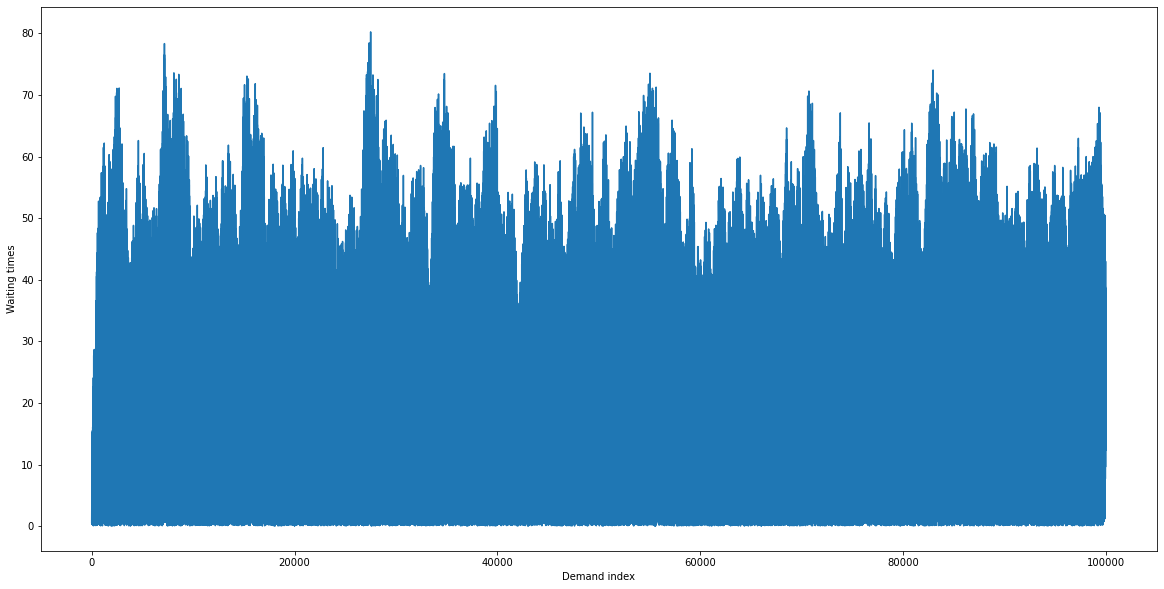

In [25]:
plt.figure(figsize=(20, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

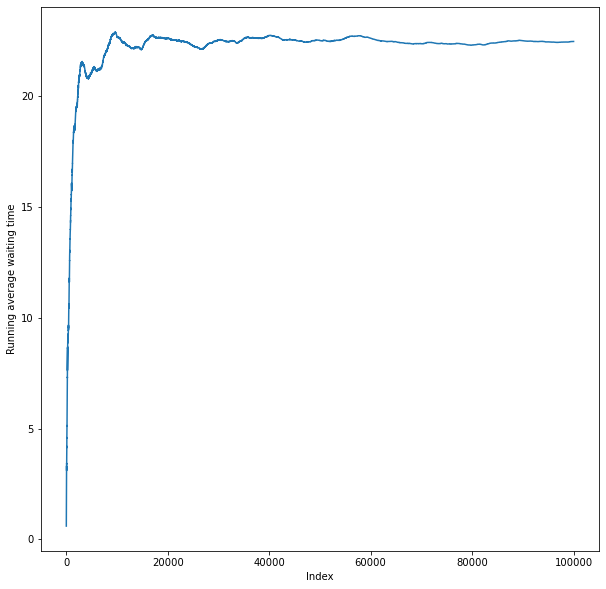

In [26]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), convergence)

#plt.ylim(76, 80)
plt.title('')
plt.xlabel('Index')
plt.ylabel('Running average waiting time')
plt.show()

In [27]:
warm_up_period = 60000
sample_size = 1000

number_of_samples = int((simulation_demands_amount-warm_up_period)/sample_size)
print(f"number of samples = {number_of_samples}")

batch_sample = []
for j in range(number_of_samples):
    mean_sample = np.mean(result_waiting_times_array[warm_up_period+(j*sample_size):warm_up_period+((j+1)*sample_size)])
    batch_sample.append(mean_sample)
CI = [np.mean(batch_sample) - (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples)),np.mean(batch_sample) + (1.96*statistics.stdev(batch_sample)/np.sqrt(number_of_samples))]
variation = (statistics.stdev(batch_sample)**2)

print(f"Waiting time mean = {np.mean(batch_sample):.4f}")
print(f"Variation waiting time = {variation:.4f}")
print(f"Waiting time CI = [{CI[0]:.4f},{CI[1]:.4f}]")

number of samples = 40
Waiting time mean = 22.2389
Variation waiting time = 3.8449
Waiting time CI = [21.6312,22.8466]


# TO Delete

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(range(simulation_demands_amount), result_waiting_times_array)

plt.title('')
plt.xlabel('Demand index')
plt.ylabel('Waiting times')
plt.show()

In [ ]:
def Compute_TSP_Tour(I_min, tilde_n_min, theta_min, gurobi_environment, arrival_rate_Q, mu, tilde_m):
    
    model = Model(env = gurobi_environment)
    model.Params.LogToConsole = 0

    # Parameters
    M = 1e20
    B_expected = mu + (0.52/tilde_m) # On site service plus travel
    rho_Q = arrival_rate_Q*B_expected

    # Nodes set
    tilde_m_squared_min = len(I_min)
    queues = range(tilde_m_squared_min)
    queues_excl = range(1,tilde_m_squared_min)
    tour = model.addMVar((tilde_m_squared_min, tilde_m_squared_min), vtype=GRB.BINARY, name="tour")
    u = model.addMVar(tilde_m_squared_min-1, vtype= GRB.CONTINUOUS , lb = 0, ub = GRB.INFINITY)
    t = model.addMVar(tilde_m_squared_min, vtype= GRB.CONTINUOUS, lb = 0)
    
    #model.setObjective(sum(t[i]*(arrival_rate_Q+tilde_n_min[i]) for i in queues)+ sum(tour[k, l]*theta_min[k][l] for k in queues for l in queues if k != l), GRB.MINIMIZE)
    #model.setObjective(sum(t[i]*tilde_n_min[i] for i in queues) , GRB.MINIMIZE)
    model.setObjective(sum(t[i]*tilde_n_min[i] for i in queues_excl)+ sum(tour[k, l]*theta_min[k][l] for k in queues for l in queues if k != l), GRB.MINIMIZE)
    
    """CONSTRAINTS"""
    # Tour constraints
    model.addConstrs(sum(tour[i, j] for j in queues if i != j) == 1 for i in queues_excl)
    model.addConstrs(sum(tour[i, j] for i in queues if i != j) == 1 for j in queues_excl)
    model.addConstr(sum(tour[i, 0] for i in queues_excl) == 1)
    model.addConstr(sum(tour[i,i] for i in queues) == 0)
    
    """Eliminate subtours using Miller-Tucker-Zemlin (MTZ) Constraints""" 
    model.addConstrs(u[i-1] - u[j-1] + ((tilde_m_squared_min-1)*tour[i,j]) <= tilde_m_squared_min - 2 for i in queues_excl for j in queues_excl if i != j)
    
    # Arrival times constraints
    model.addConstrs(t[j] >= t[i] + (((tilde_n_min[i]*B_expected)+(t[i]*rho_Q))/(1-rho_Q)) + theta_min[i][j] - (M*(1-tour[i,j])) for i in queues for j in queues if i != j)

    model.update()
    
    model.optimize();
    optimality = model.status
    
    # Check if solution is optimal
    if (model.status==GRB.OPTIMAL):
        #print(f"Optimal solution? {model.status==GRB.OPTIMAL}")
        result = tour.X
    else:
        print(f"Optimal solution? False")
        result = 0
        
    return result, optimality
